## Setup, Loading Data and CDFs

In [12]:
DATA_NAME = 'approx1e5-pastis-wavelet-green' # Dataset Format: size-name-transform-channel

In [13]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
RERUN = True
CWD

'/Users/michaelmurphy/Documents/GitHub/hierarchical-bayesian-model-validation/results/case-studies/pastis/wavelet/approx1e5/green'

In [14]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [15]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if path_dict['transform'] == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif path_dict['transform'] == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::1000] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 3180, 3: 12720, 4: 50880, 5: 203520, 6: 814080, 7: 3256320, 8: 13025280}

In [16]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
all_cdfs_df.head()

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.02, -1.4), <scipy.interpolate._fitpack2.In...",0.02,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,9.618487e+69,1.391529e+25
1,"((0.02, -1.3), <scipy.interpolate._fitpack2.In...",0.02,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.821735e+74,8.172634e+21
2,"((0.02, -1.2), <scipy.interpolate._fitpack2.In...",0.02,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.455488e+78,4.131785e+19
3,"((0.02, -1.1), <scipy.interpolate._fitpack2.In...",0.02,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.406735e+81,6.947275e+17
4,"((0.02, -1.0), <scipy.interpolate._fitpack2.In...",0.02,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.331443e+83,2.562075e+16


## Bootstrapping the Variance and Kurtosis

In [17]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [18]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:16<00:00, 5885.00it/s]


Layer 3


100%|██████████| 100000/100000 [00:22<00:00, 4369.72it/s]


Layer 4


100%|██████████| 100000/100000 [00:22<00:00, 4459.07it/s]


Layer 5


100%|██████████| 100000/100000 [00:23<00:00, 4225.40it/s]


Layer 6


100%|██████████| 100000/100000 [00:22<00:00, 4356.06it/s]


Layer 7


100%|██████████| 100000/100000 [00:23<00:00, 4241.10it/s]


Layer 8


100%|██████████| 100000/100000 [00:23<00:00, 4332.00it/s]


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,1829.164000,1651.372800,2019.902600,2.873299,1.840007,4.012415,3180.0
3,577.966500,547.148500,610.217350,2.591534,2.004859,3.274253,12720.0
4,161.064830,151.595140,170.843120,3.336077,2.644728,4.188527,50880.0
5,37.128075,34.705720,39.643353,4.760657,3.808561,5.902313,203520.0
6,7.465013,6.910058,8.046522,6.556909,5.074348,8.726763,814080.0
7,1.416197,1.301939,1.538062,8.566812,6.601404,11.716293,3256320.0
8,0.229009,0.208696,0.252363,11.555227,7.821531,25.041437,13025280.0


## Initial Grid Search and Hypothesis Test Plots

In [19]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        
        group_cdf_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / group_cdf_df['variance'], 0, 1e5)
        ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdf_df['scale'])
        initial_scale = group_cdf_df.loc[(group_cdf_df["r"] ==  initial_param[0]) & (group_cdf_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
        master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
        master_df.loc[group, 'initial_scale'] = initial_scale
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        master_df.loc[group, 'kstest_stat_initial'] = min_stat
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df['variance'] = group_cdf_df['variance'] * group_cdf_df['scale']
        group_cdf_df['kurtosis'] = group_cdf_df['kurtosis'] * group_cdf_df['scale']

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

####
Layer  2


100%|██████████| 55966/55966 [00:24<00:00, 2254.23it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 3180, Without approximation : 3180.0
####
Layer  3


100%|██████████| 55966/55966 [00:28<00:00, 1986.69it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 12720, Without approximation : 12720.0
####
Layer  4


100%|██████████| 55966/55966 [01:37<00:00, 573.05it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 50880, Without approximation : 50880.0
####
Layer  5


100%|██████████| 55966/55966 [03:11<00:00, 292.19it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 203520.0
####
Layer  6


100%|██████████| 55966/55966 [03:13<00:00, 289.93it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 814080.0
####
Layer  7


100%|██████████| 55966/55966 [03:34<00:00, 261.28it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 3256320.0
####
Layer  8


100%|██████████| 55966/55966 [03:28<00:00, 268.18it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 13025280.0


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,initial_scale,kstest_stat_initial,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,,
2,1829.164000,1651.372800,2019.902600,2.873299,1.840007,4.012415,3180.0,0.74,2.000000e-01,5.422004e+02,0.017426,0.024030
3,577.966500,547.148500,610.217350,2.591534,2.004859,3.274253,12720.0,0.27,2.700000e+00,1.646114e-02,0.005168,0.012029
4,161.064830,151.595140,170.843120,3.336077,2.644728,4.188527,50880.0,0.32,1.000000e+00,1.779560e-01,0.004541,0.006018
5,37.128075,34.705720,39.643353,4.760657,3.808561,5.902313,203520.0,0.40,1.000000e-09,8.883273e-01,0.002006,0.003010
6,7.465013,6.910058,8.046522,6.556909,5.074348,8.726763,814080.0,0.32,-1.000000e-01,3.908385e-02,0.003306,0.001505
7,1.416197,1.301939,1.538062,8.566812,6.601404,11.716293,3256320.0,0.17,6.000000e-01,1.926517e-07,0.007723,0.000753
8,0.229009,0.208696,0.252363,11.555227,7.821531,25.041437,13025280.0,0.12,1.400000e+00,2.163815e-13,0.025920,0.000376


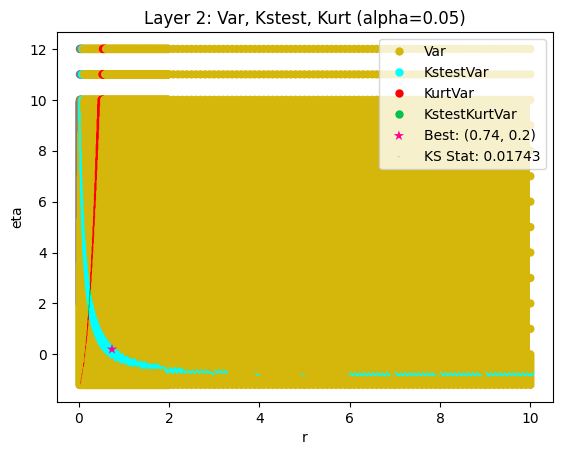

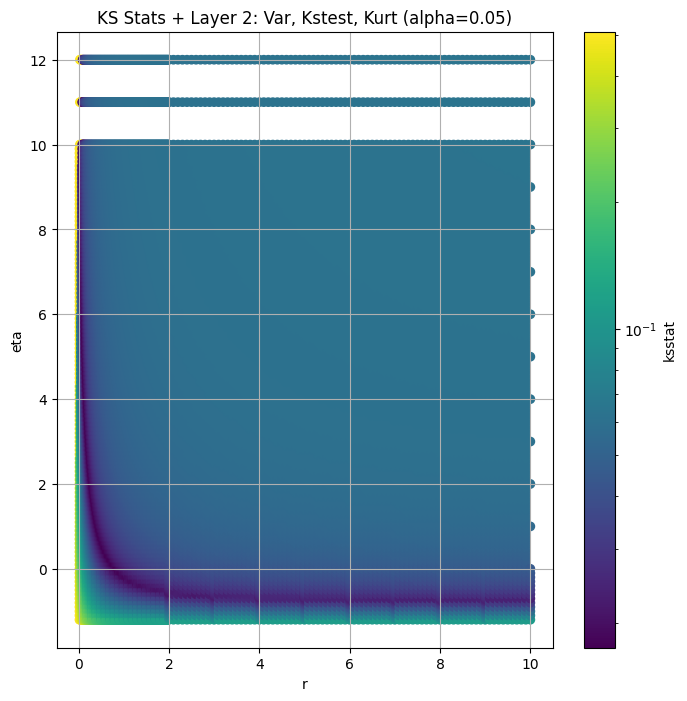

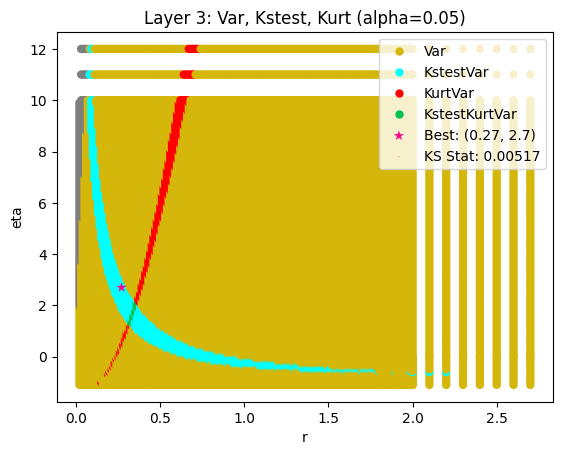

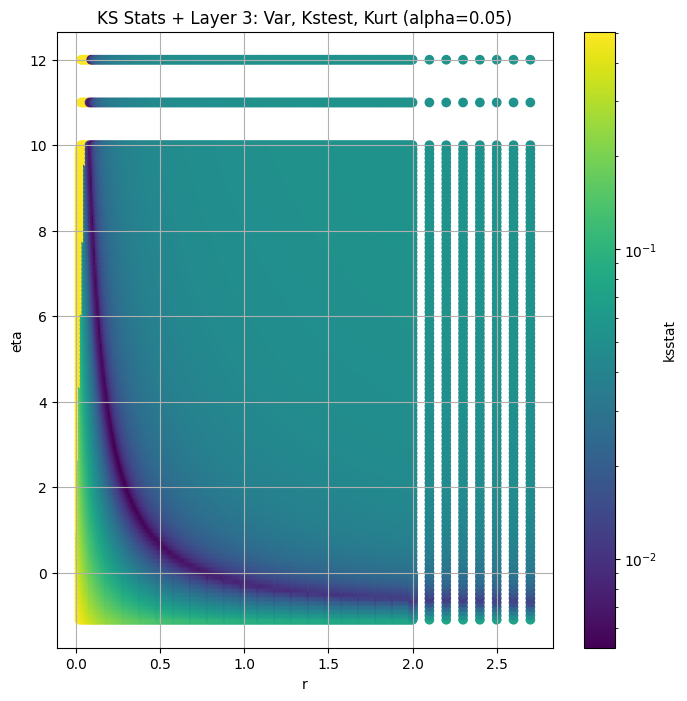

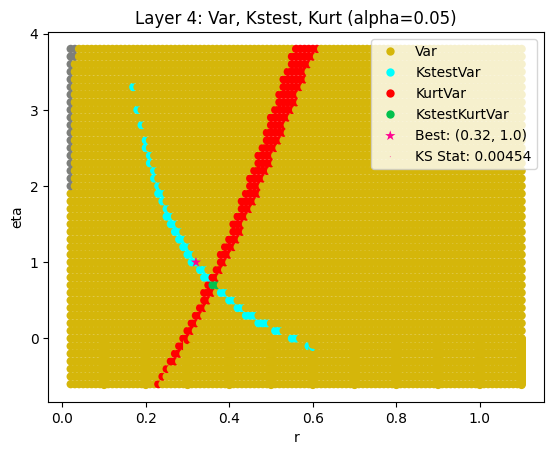

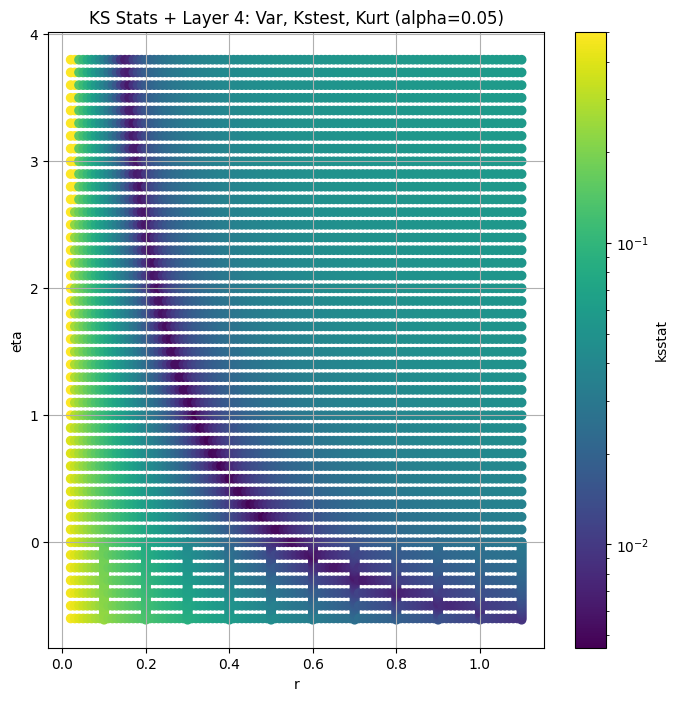

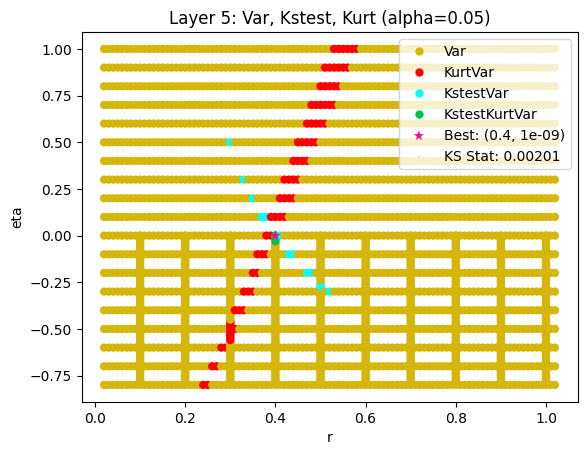

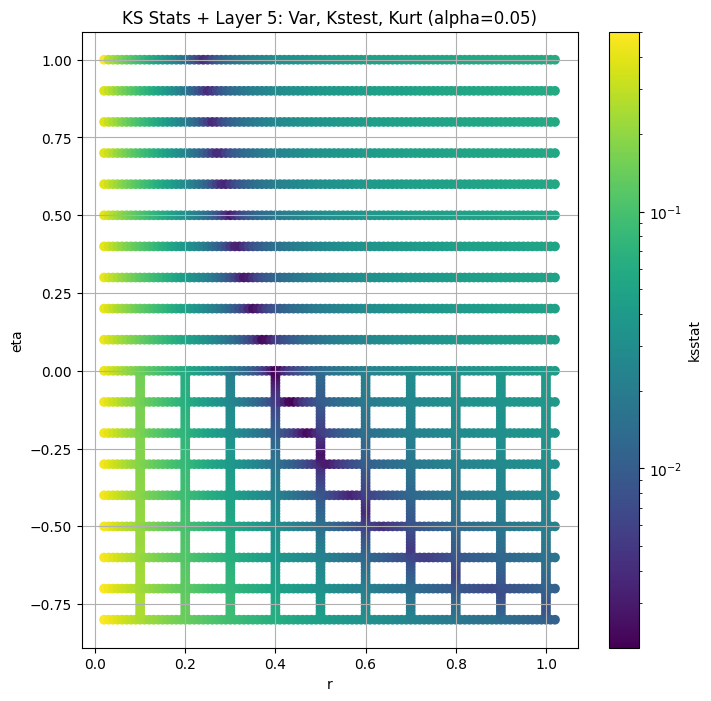

0
6 after 0


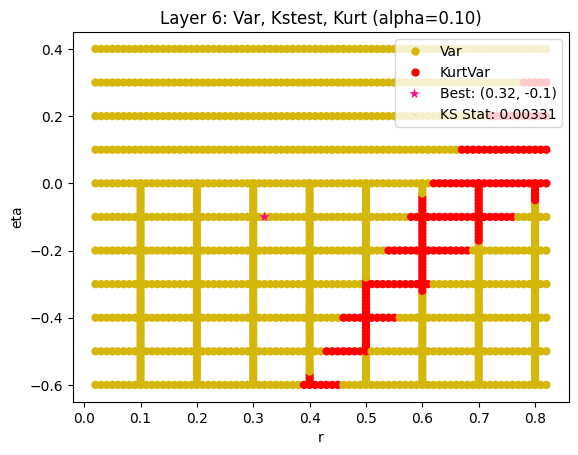

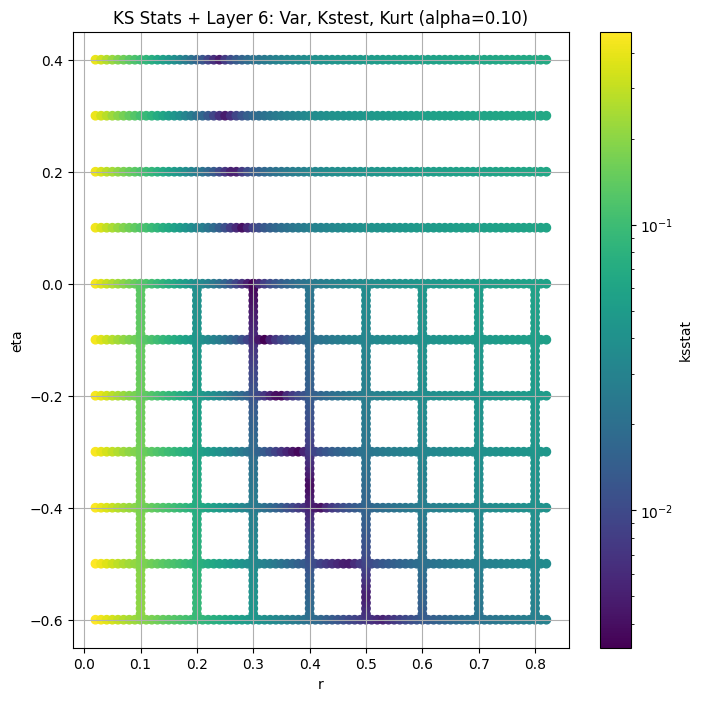

0
7 after 0


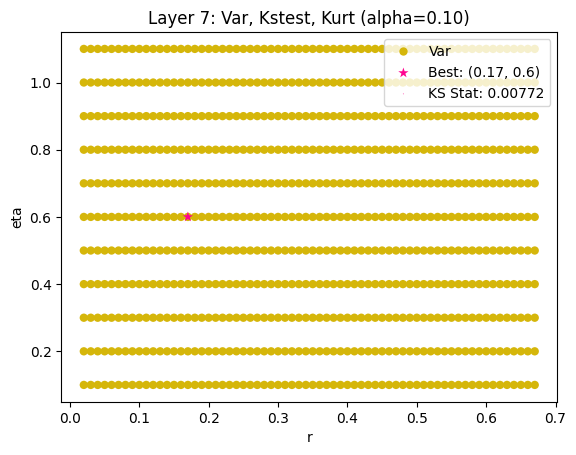

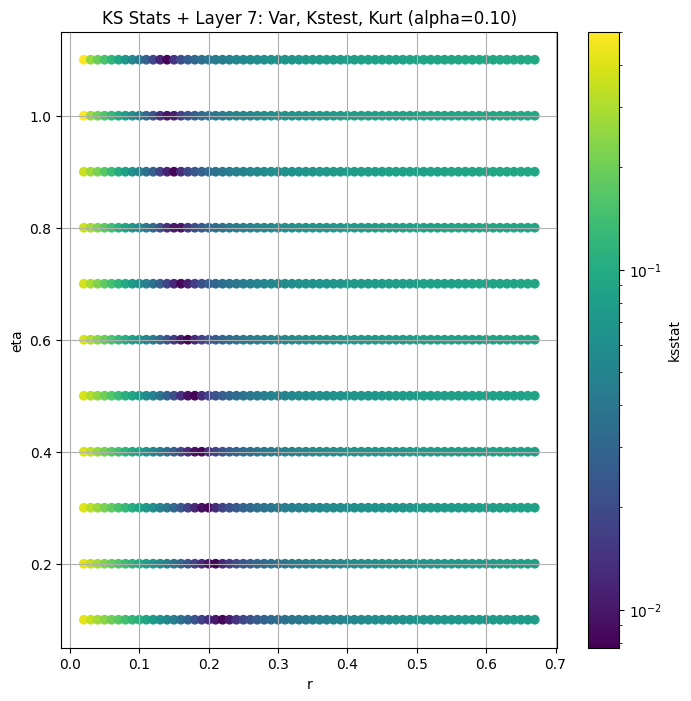

0
8 after 0


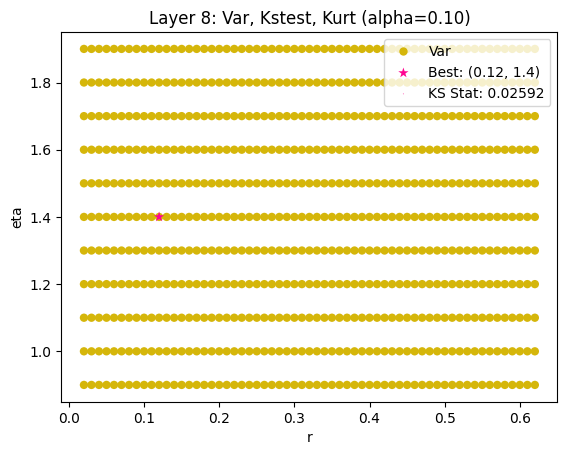

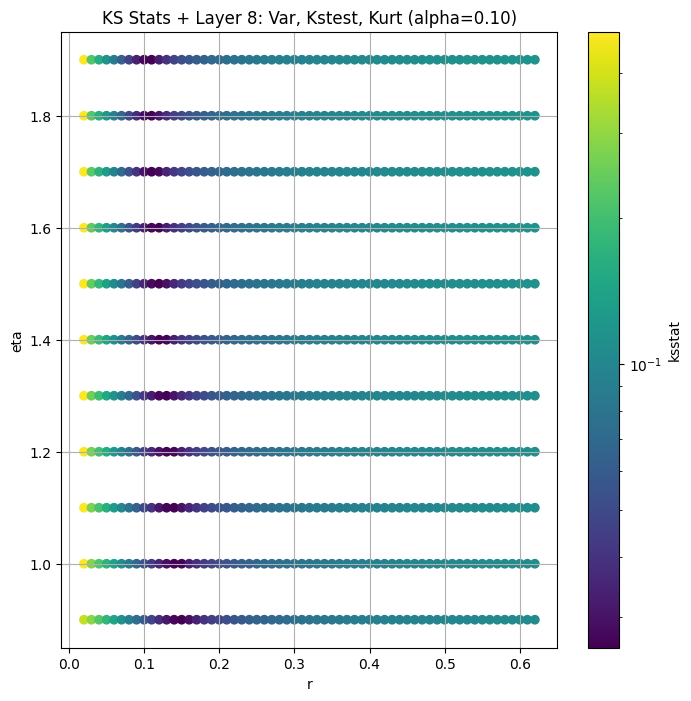

In [20]:
for i, group in enumerate(GROUPS):

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']
        
        if sum(group_cdf_df_dict[group]['pass_kstest'] & group_cdf_df_dict[group]['pass_kurt']) == 0:
                print(sum(group_cdf_df_dict[group]['pass_kstest']))
                cutoff = stats.kstwo(n=var_kurt_df.loc[group, 'total_samples']).isf(0.10)
                group_cdf_df_dict[group]['pass_kstest'] = group_cdf_df_dict[group]['ksstat'].apply(lambda x: True if x < cutoff else False)
                print(group, "after", sum(group_cdf_df_dict[group]['pass_kstest']))

                fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                                plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} (alpha=0.10)", 
                                target_var = None,
                                best_param = (master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta']),
                                best_ksstat= master_df.loc[group, 'kstest_stat_initial']
                                )
        else: 
                fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                                plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} (alpha=0.05)", 
                                target_var = None,
                                best_param = (master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta']),
                                best_ksstat= master_df.loc[group, 'kstest_stat_initial']
                                )
        

        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)
        
        
        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

### Search over $\eta=0$

In [21]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True, scales=group_cdf_df['scale'])
            best_scale_eta0 = group_cdf_df.loc[(group_cdf_df["r"] ==  best_param_eta0[0]) & (group_cdf_df["eta"] ==  best_param_eta0[1])]["scale"].iloc[0]
            master_df.loc[group, 'best_r_eta0'] = best_param_eta0[0]
            master_df.loc[group, 'best_scale_eta0'] = best_scale_eta0
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r_eta0'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_scale_eta0'] = master_df.loc[group, 'initial_scale']
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

100%|██████████| 369/369 [00:00<00:00, 3505.47it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 2317.95it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 601.00it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 294.34it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 303.85it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 302.64it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 300.91it/s]

Finding Minimum after computing 369 CDFs


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,initial_scale,kstest_stat_initial,kstest_stat_cutoff_0.05,best_r_eta0,best_scale_eta0,kstest_stat_eta0
layer,,,,,,,,,,,,,,,
2,1829.164000,1651.372800,2019.902600,2.873299,1.840007,4.012415,3180.0,0.74,2.000000e-01,5.422004e+02,0.017426,0.024030,6.00,3.902591e-01,0.327732
3,577.966500,547.148500,610.217350,2.591534,2.004859,3.274253,12720.0,0.27,2.700000e+00,1.646114e-02,0.005168,0.012029,5.90,3.900000e-01,0.382057
4,161.064830,151.595140,170.843120,3.336077,2.644728,4.188527,50880.0,0.32,1.000000e+00,1.779560e-01,0.004541,0.006018,5.80,3.897203e-01,0.424550
5,37.128075,34.705720,39.643353,4.760657,3.808561,5.902313,203520.0,0.40,1.000000e-09,8.883273e-01,0.002006,0.003010,5.80,3.897203e-01,0.455943
6,7.465013,6.910058,8.046522,6.556909,5.074348,8.726763,814080.0,0.32,-1.000000e-01,3.908385e-02,0.003306,0.001505,5.80,3.897203e-01,0.475720
7,1.416197,1.301939,1.538062,8.566812,6.601404,11.716293,3256320.0,0.17,6.000000e-01,1.926517e-07,0.007723,0.000753,5.80,3.897203e-01,0.487031
8,0.229009,0.208696,0.252363,11.555227,7.821531,25.041437,13025280.0,0.12,1.400000e+00,2.163815e-13,0.025920,0.000376,0.03,6.726987e-62,0.479040


## Optimization

In [22]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

Layer 2
(0.73, 0.18), 450 of 882
(0.732, 0.26), 500 of 882
(0.735, 0.13), 550 of 882
(0.737, 0.21), 600 of 882
(0.739, 0.29), 650 of 882
(0.742, 0.16), 700 of 882
(0.744, 0.24), 750 of 882
(0.747, 0.11), 800 of 882
(0.749, 0.19), 850 of 882


100%|██████████| 882/882 [00:00<00:00, 9008.46it/s]


Finding Minimum after computing 882 CDFs
Iter 1 layer 2 best parameters: ((0.744, 0.19), 0.01736920198252012)


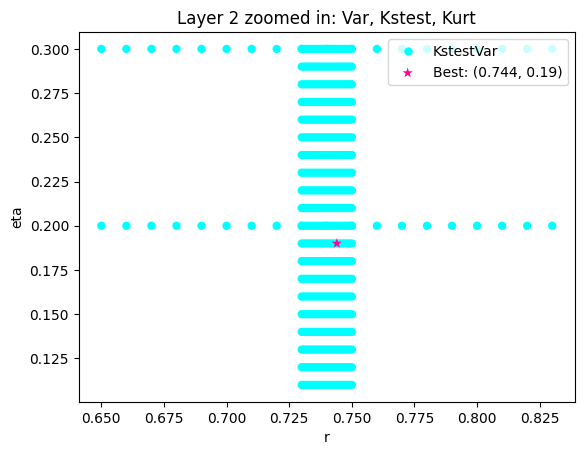

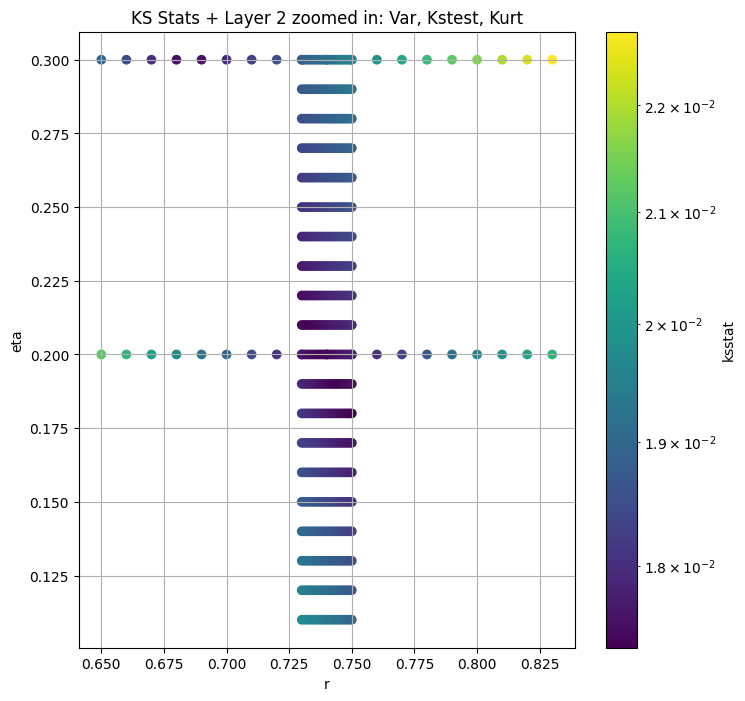

Layer 3
(0.26, 2.68), 450 of 882
(0.262, 2.76), 500 of 882
(0.265, 2.63), 550 of 882
(0.267, 2.71), 600 of 882
(0.269, 2.79), 650 of 882
(0.272, 2.66), 700 of 882
(0.274, 2.74), 750 of 882
(0.277, 2.61), 800 of 882
(0.279, 2.69), 850 of 882


100%|██████████| 882/882 [00:00<00:00, 2333.74it/s]


Finding Minimum after computing 882 CDFs
Iter 1 layer 3 best parameters: ((0.265, 2.79), 0.005149505310139024)


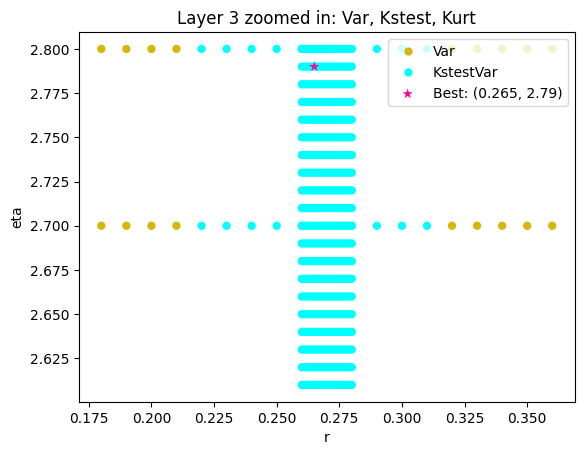

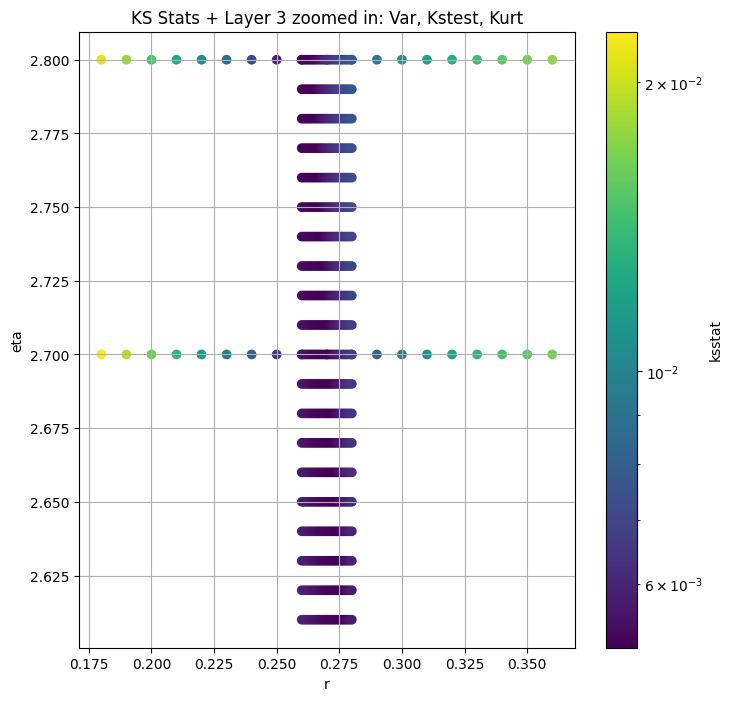

Layer 4
(0.311, 0.98), 450 of 861
(0.313, 1.06), 500 of 861
(0.316, 0.93), 550 of 861
(0.318, 1.01), 600 of 861
(0.32, 1.09), 650 of 861
(0.323, 0.96), 700 of 861
(0.325, 1.04), 750 of 861
(0.328, 0.91), 800 of 861
(0.33, 0.99), 850 of 861


100%|██████████| 861/861 [00:01<00:00, 572.79it/s]


Finding Minimum after computing 861 CDFs
Iter 1 layer 4 best parameters: ((0.33, 0.92), 0.004465754889066198)


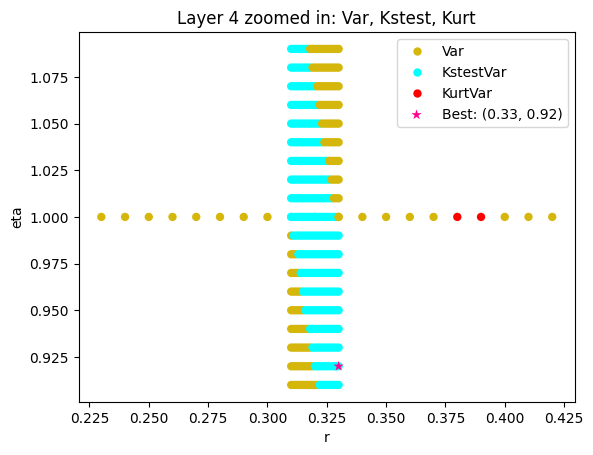

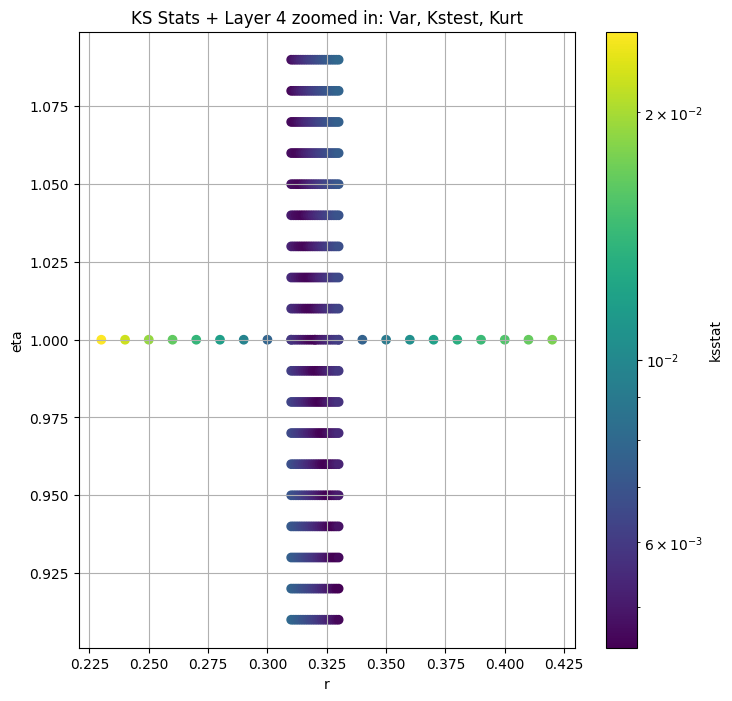

Layer 5
(0.32, -0.009999999), 450 of 800
(0.34, 0.090000001), 500 of 800
(0.37, -0.009999999), 550 of 800
(0.39, 0.090000001), 600 of 800
(0.42, -0.009999999), 650 of 800
(0.44, 0.090000001), 700 of 800
(0.47, -0.009999999), 750 of 800
(0.49, 0.090000001), 800 of 800


100%|██████████| 800/800 [00:02<00:00, 286.25it/s]


Finding Minimum after computing 800 CDFs
Iter 1 layer 5 best parameters: ((0.42, -0.054), 0.001895652277406068)


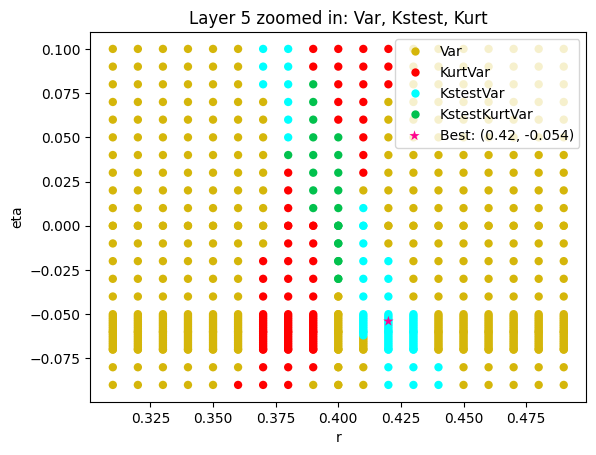

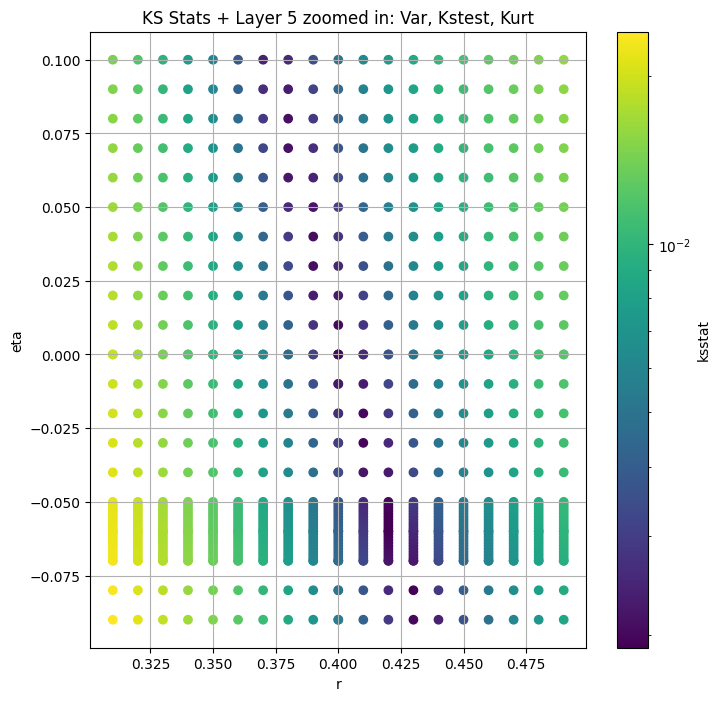

Layer 6
(0.311, -0.11), 450 of 840
(0.313, -0.01), 500 of 840
(0.316, -0.11), 550 of 840
(0.318, -0.01), 600 of 840
(0.321, -0.11), 650 of 840
(0.323, -0.01), 700 of 840
(0.326, -0.11), 750 of 840
(0.328, -0.01), 800 of 840


100%|██████████| 840/840 [00:02<00:00, 285.62it/s]


Finding Minimum after computing 840 CDFs
Iter 1 layer 6 best parameters: ((0.314, -0.07), 0.0032818377743005223)


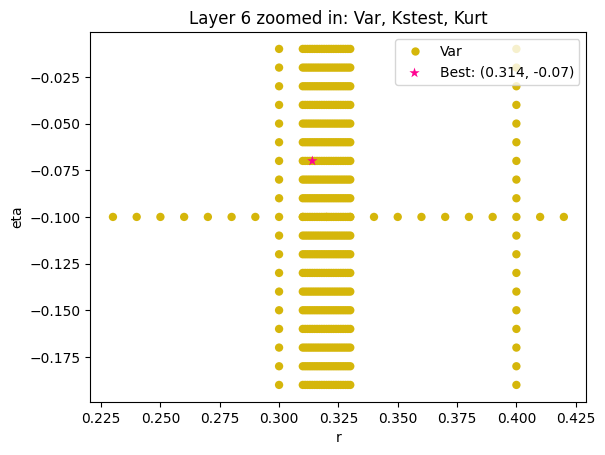

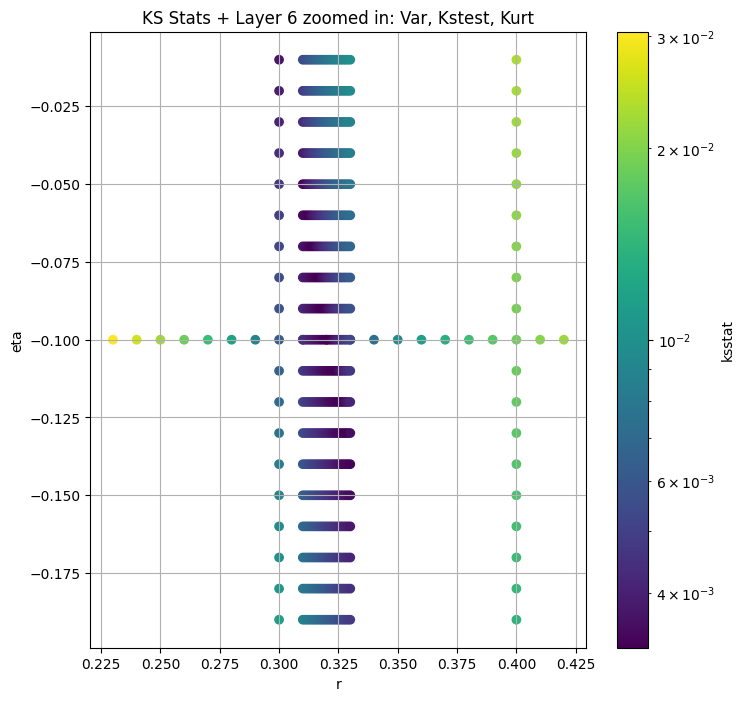

Layer 7
(0.161, 0.59), 450 of 840
(0.163, 0.69), 500 of 840
(0.166, 0.59), 550 of 840
(0.168, 0.69), 600 of 840
(0.171, 0.59), 650 of 840
(0.173, 0.69), 700 of 840
(0.176, 0.59), 750 of 840
(0.178, 0.69), 800 of 840


100%|██████████| 840/840 [00:02<00:00, 289.78it/s]


Finding Minimum after computing 840 CDFs
Iter 1 layer 7 best parameters: ((0.165, 0.68), 0.007609999999997452)


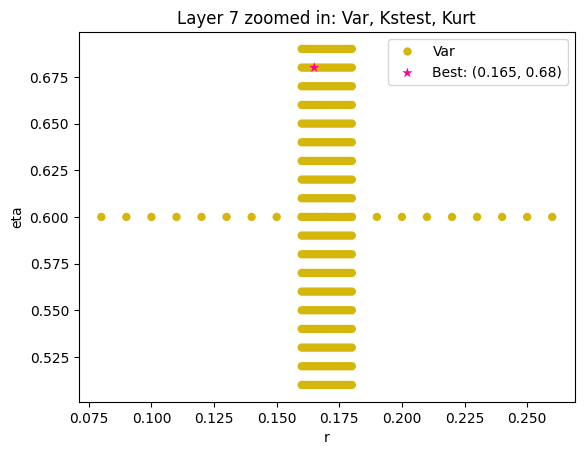

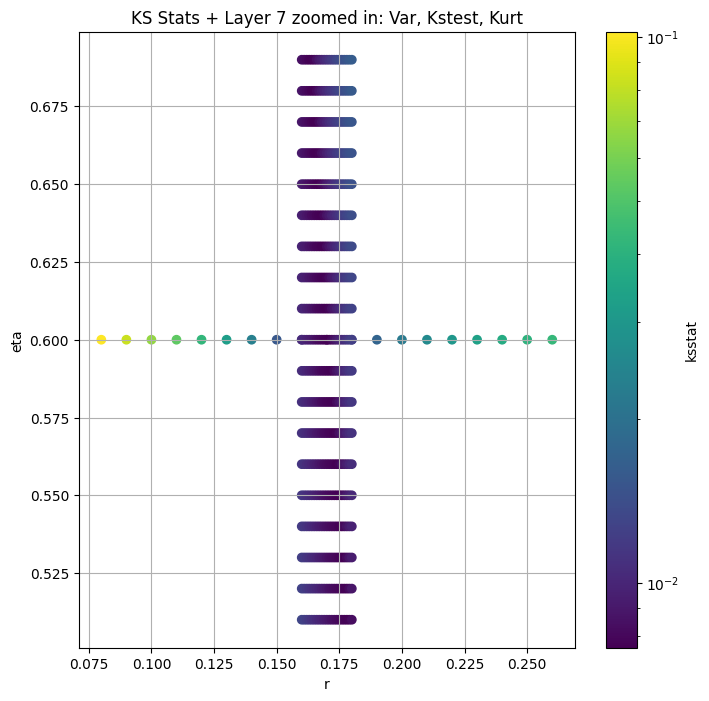

Layer 8
(0.111, 1.38), 450 of 861
(0.113, 1.46), 500 of 861
(0.116, 1.33), 550 of 861
(0.118, 1.41), 600 of 861
(0.12, 1.49), 650 of 861
(0.123, 1.36), 700 of 861
(0.125, 1.44), 750 of 861
(0.128, 1.31), 800 of 861
(0.13, 1.39), 850 of 861


100%|██████████| 861/861 [00:02<00:00, 287.34it/s]


Finding Minimum after computing 861 CDFs
Iter 1 layer 8 best parameters: ((0.12, 1.42), 0.02591999999999184)


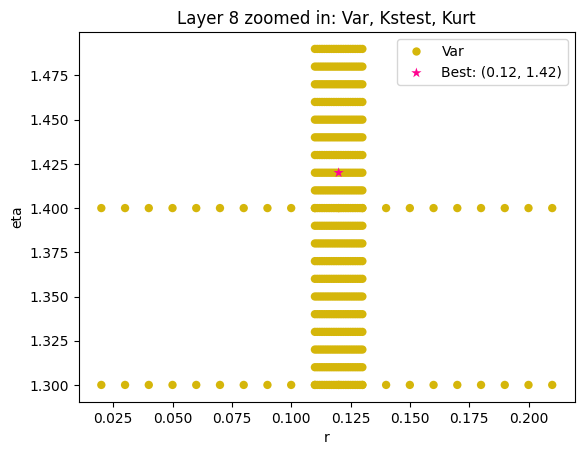

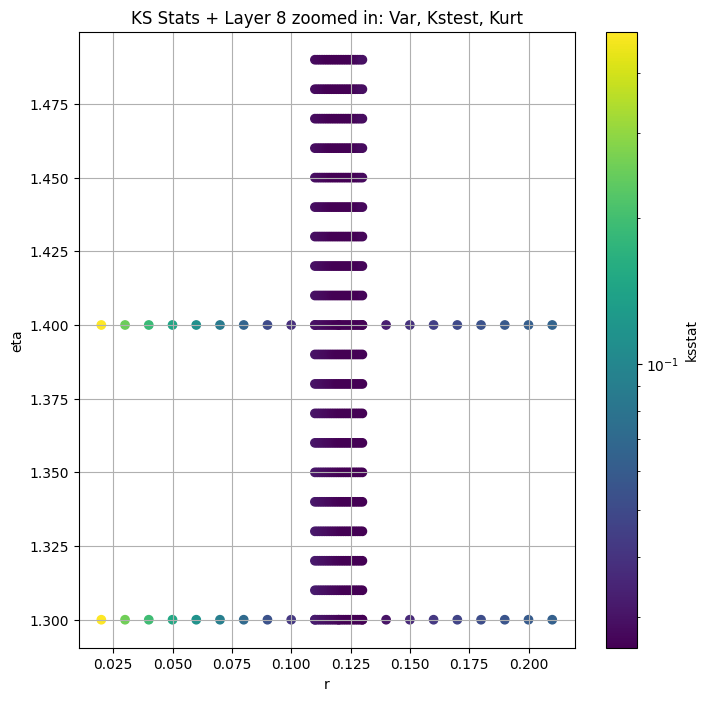

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,initial_scale,...,best_scale_eta0,kstest_stat_eta0,best_r,best_eta,best_scale,kstest_stat_best,iter1_r,iter1_eta,kstest_stat_iter1,n_pval_0.05
layer,,,,,,,,,,,,,,,,,,,,,
2,1829.164000,1651.372800,2019.902600,2.873299,1.840007,4.012415,3180.0,0.74,2.000000e-01,5.422004e+02,...,3.902591e-01,0.327732,0.744,0.190,5.546063e+02,0.017369,0.744,0.190,0.017369,6034
3,577.966500,547.148500,610.217350,2.591534,2.004859,3.274253,12720.0,0.27,2.700000e+00,1.646114e-02,...,3.900000e-01,0.382057,0.265,2.790,1.167013e-02,0.005150,0.265,2.790,0.005150,72444
4,161.064830,151.595140,170.843120,3.336077,2.644728,4.188527,50880.0,0.32,1.000000e+00,1.779560e-01,...,3.897203e-01,0.424550,0.330,0.920,2.634729e-01,0.004466,0.330,0.920,0.004466,96592
5,37.128075,34.705720,39.643353,4.760657,3.808561,5.902313,203520.0,0.40,1.000000e-09,8.883273e-01,...,3.897203e-01,0.455943,0.420,-0.054,1.300979e+00,0.001896,0.420,-0.054,0.001896,515160
6,7.465013,6.910058,8.046522,6.556909,5.074348,8.726763,814080.0,0.32,-1.000000e-01,3.908385e-02,...,3.897203e-01,0.475720,0.314,-0.070,3.130878e-02,0.003282,0.314,-0.070,0.003282,171720
7,1.416197,1.301939,1.538062,8.566812,6.601404,11.716293,3256320.0,0.17,6.000000e-01,1.926517e-07,...,3.897203e-01,0.487031,0.165,0.680,8.168146e-08,0.007610,0.165,0.680,0.007610,32197
8,0.229009,0.208696,0.252363,11.555227,7.821531,25.041437,13025280.0,0.12,1.400000e+00,2.163815e-13,...,6.726987e-62,0.479040,0.120,1.420,2.058037e-13,0.025920,0.120,1.420,0.025920,2682


In [23]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / temp_df['variance'], 0, 1e5)
                temp_df['variance'] = temp_df['variance'] * temp_df['scale']
                temp_df['kurtosis'] = temp_df['kurtosis'] * temp_df['scale']
                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True, scales= temp_df['scale'])
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                best_scale = temp_df.loc[(temp_df["r"] ==  best_param[0])&(temp_df["eta"] ==  best_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'best_scale'] = best_scale
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.1
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']))
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

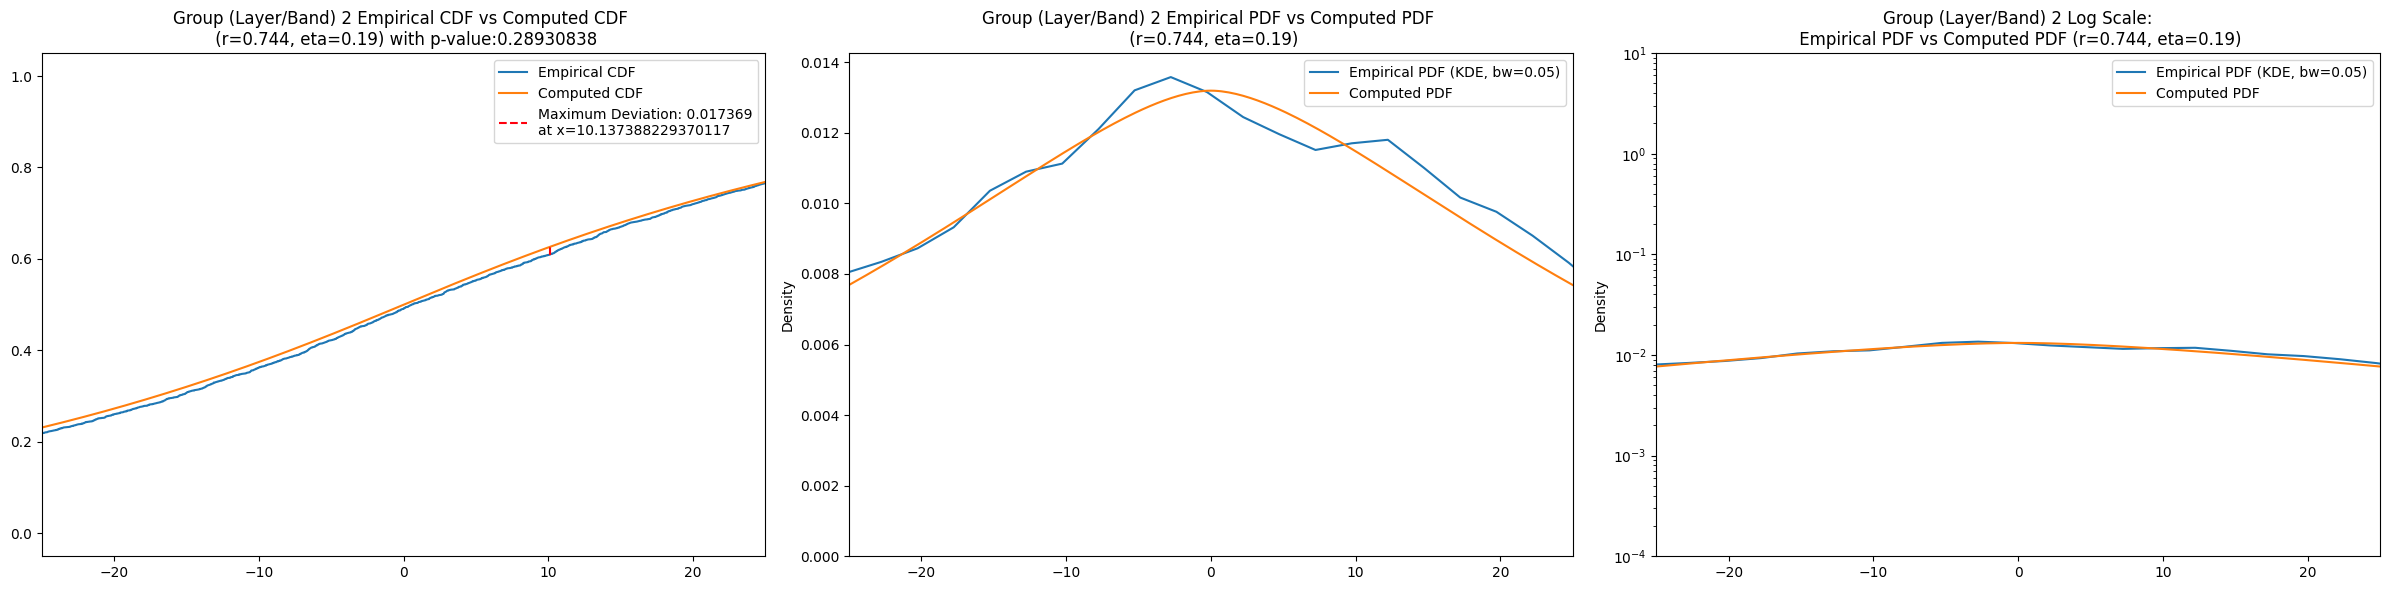

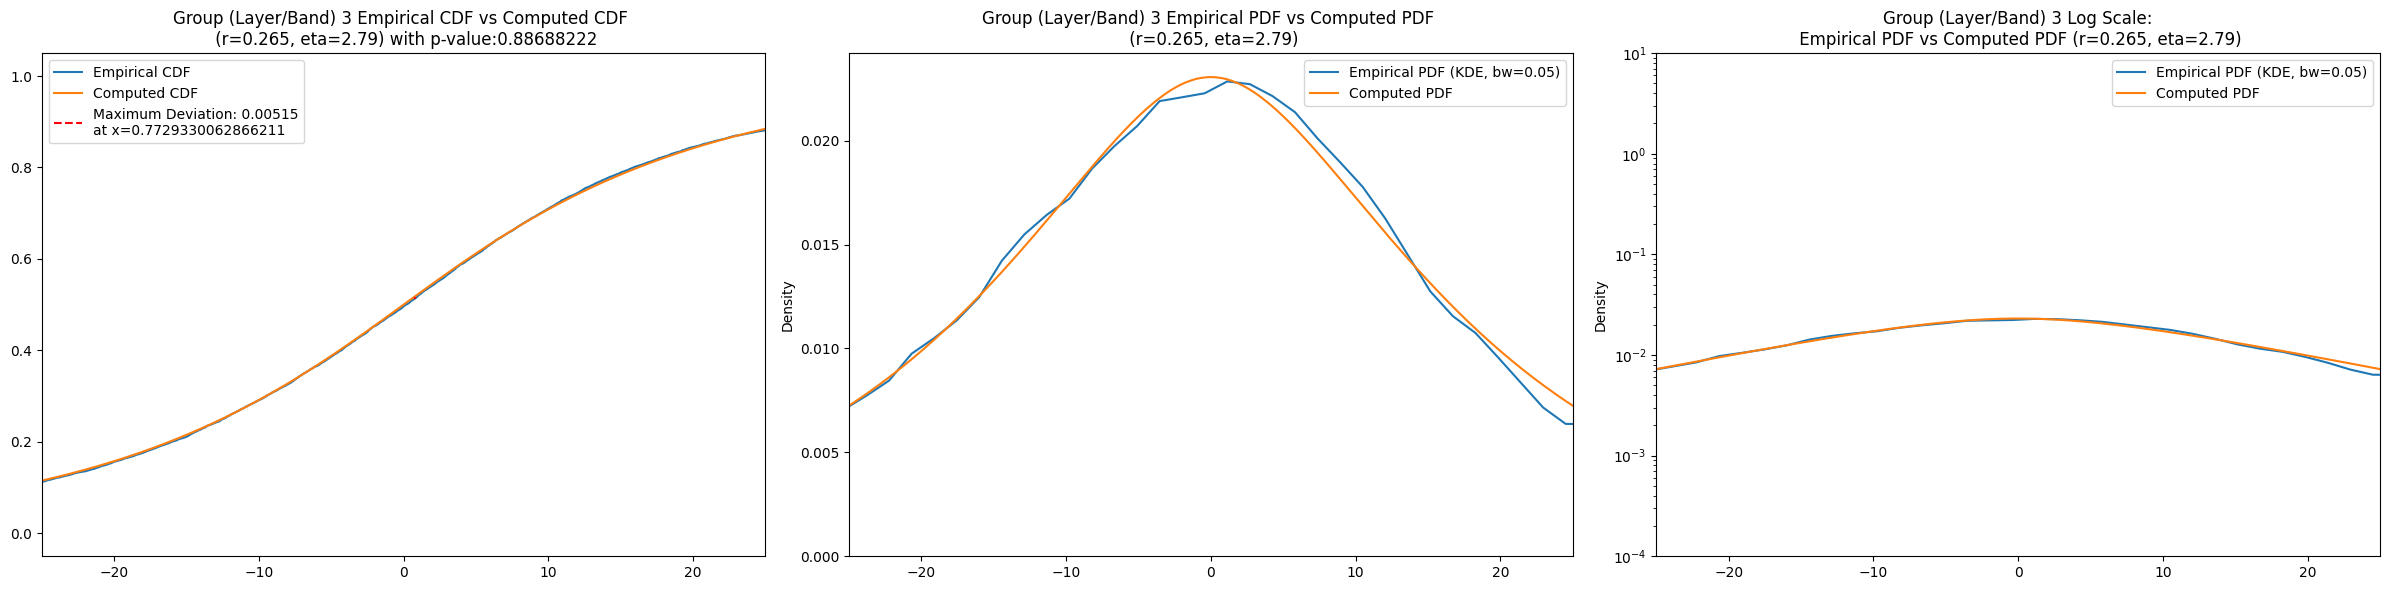

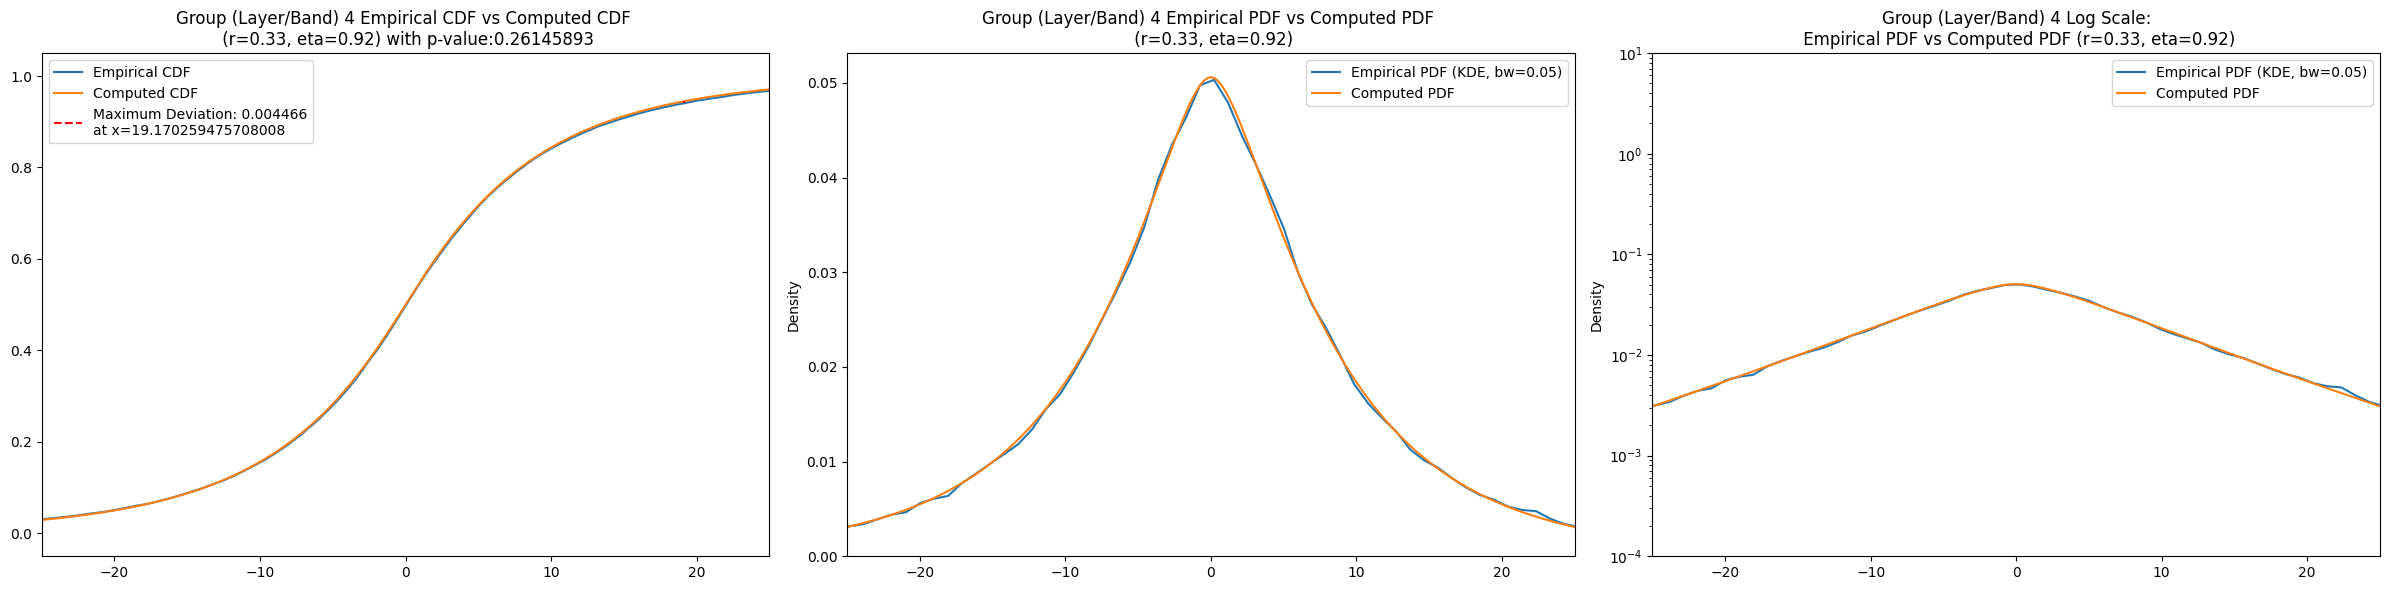

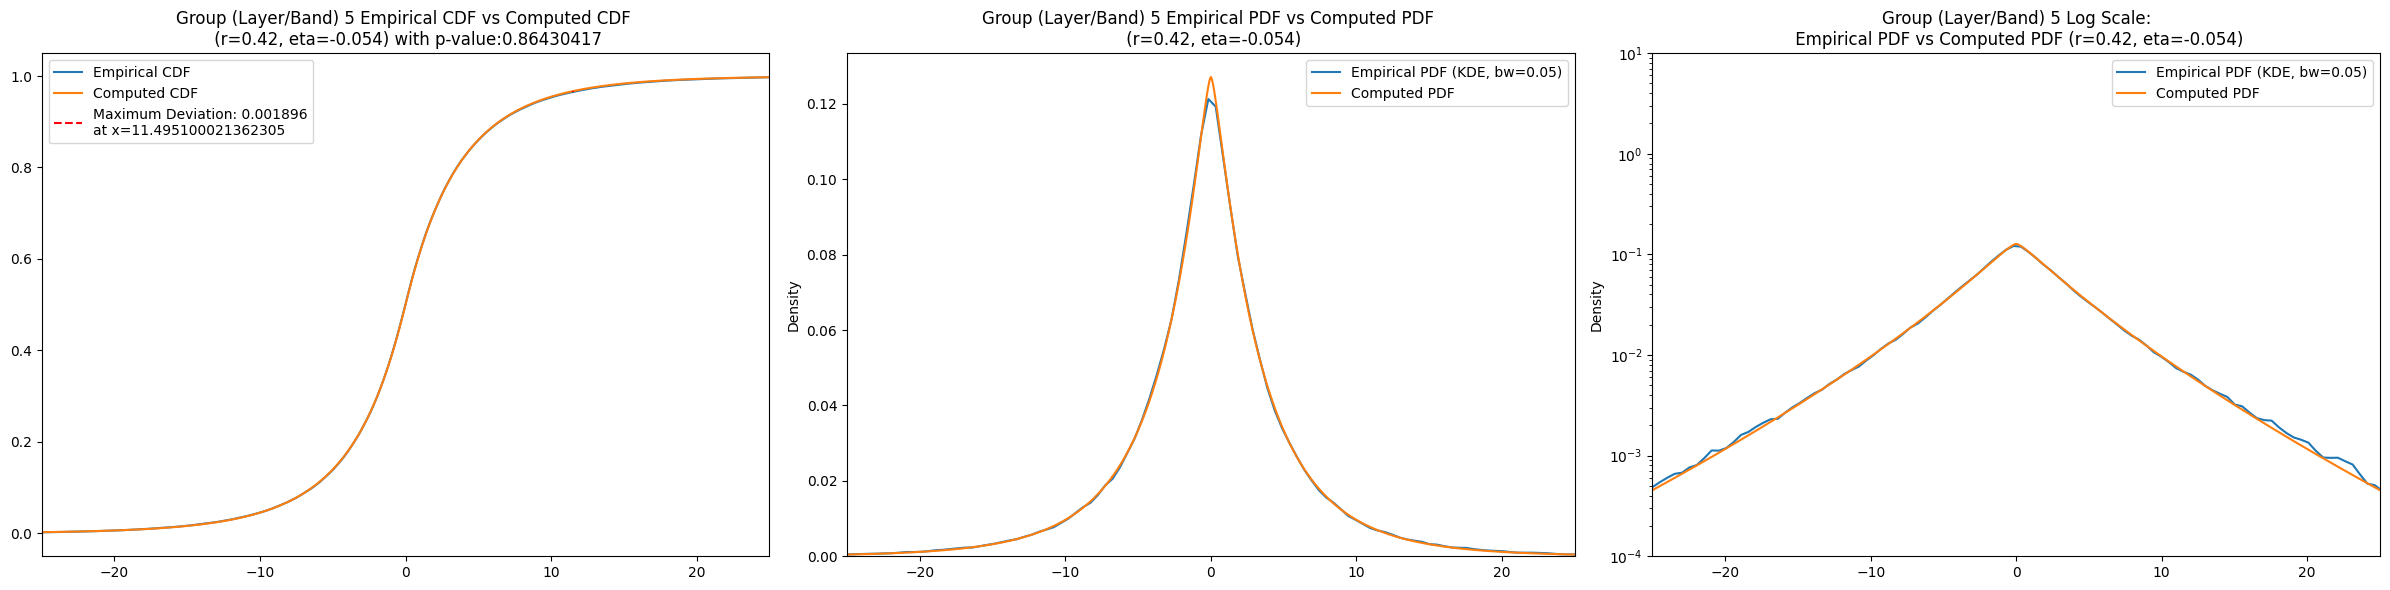

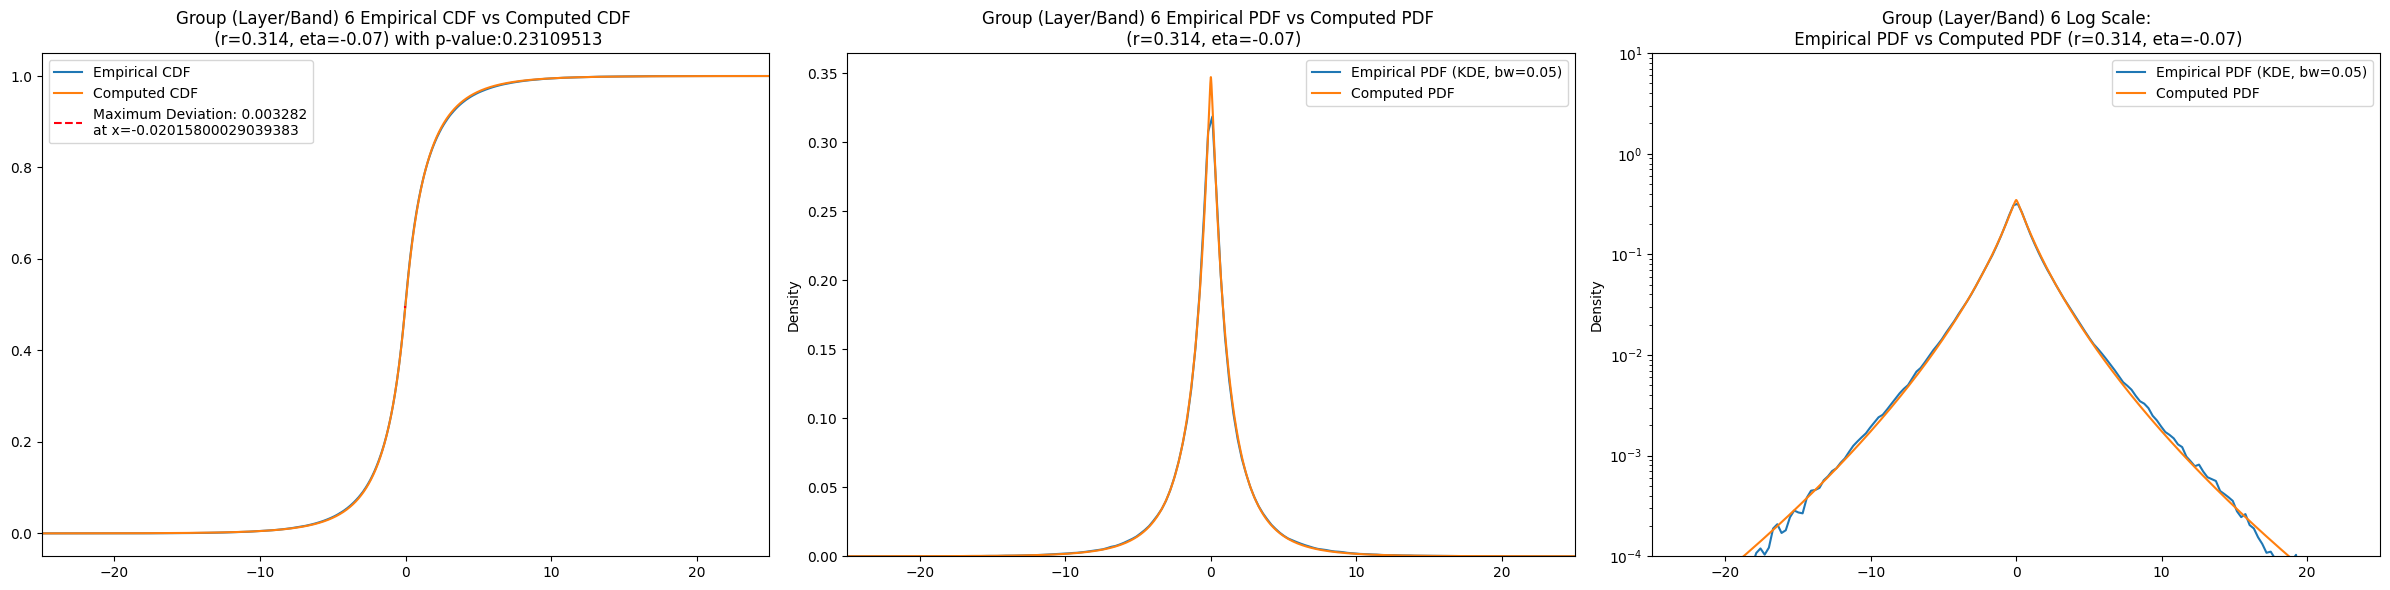

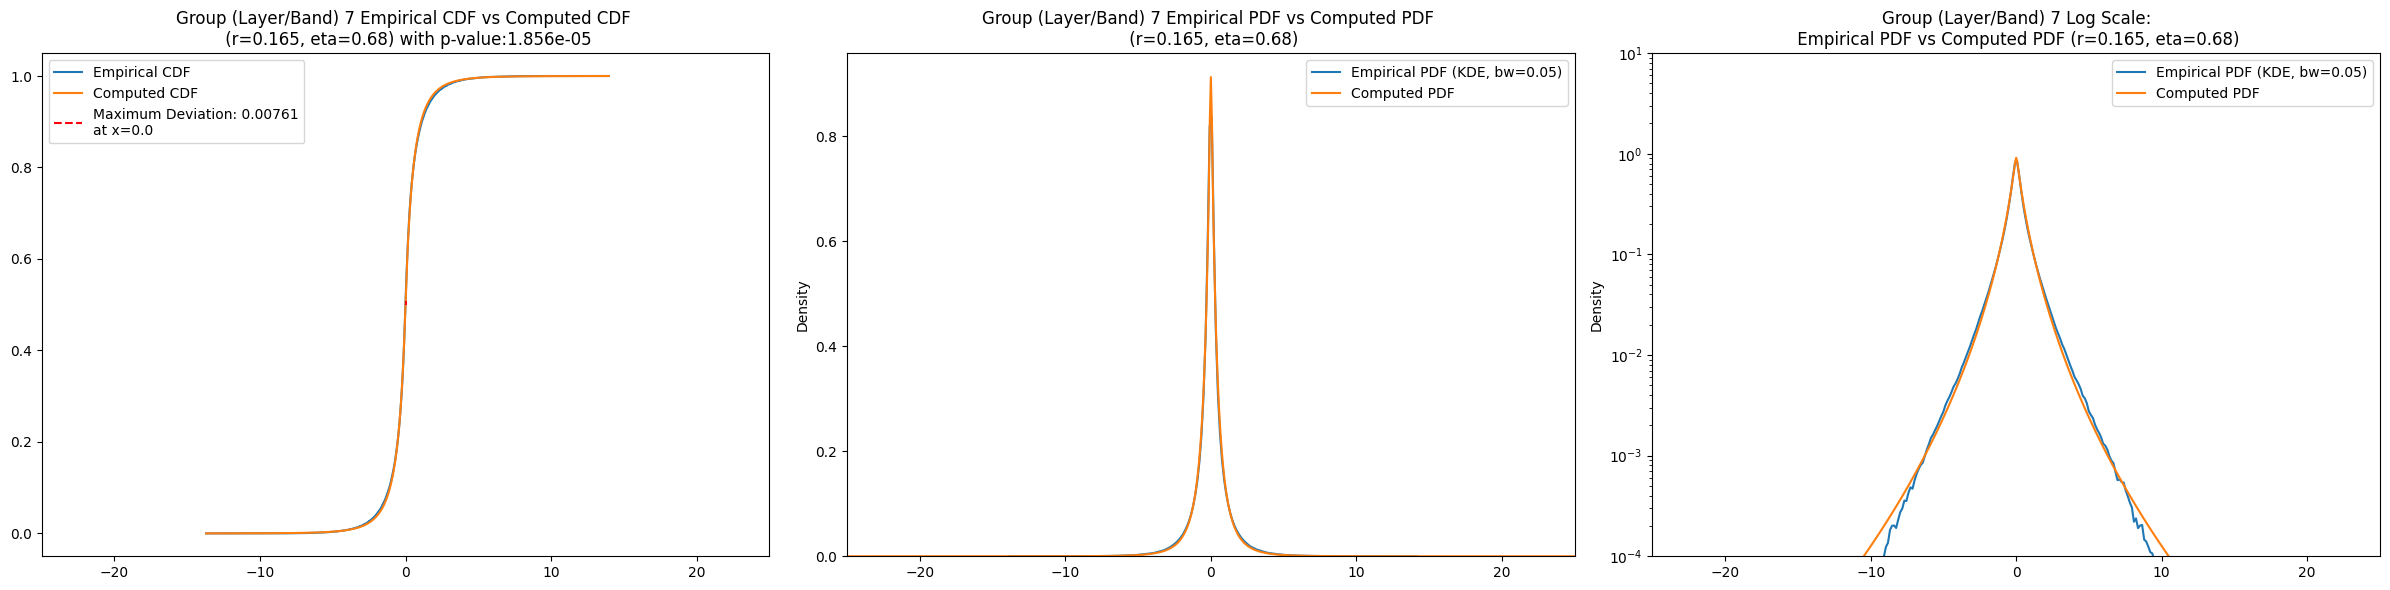

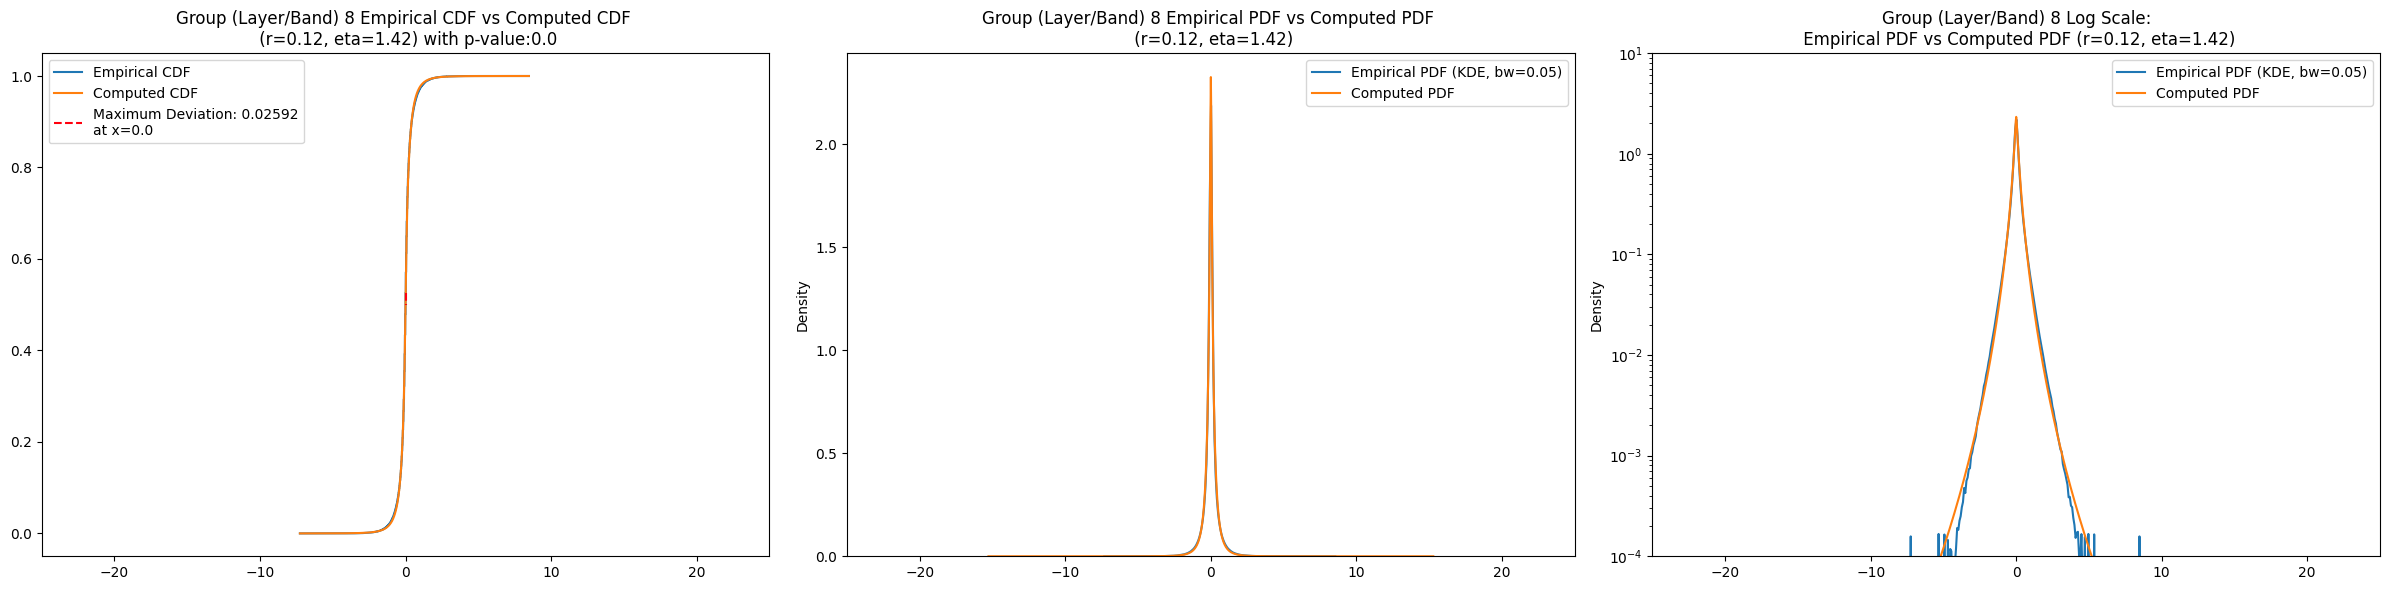

In [24]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [25]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample / np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [26]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,initial_scale,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,1829.164000,1651.372800,2019.902600,2.873299,1.840007,4.012415,3180.0,0.74,2.000000e-01,5.422004e+02,...,35.389200,0.031293,3.861410e-03,32.846500,0.023339,6.160030e-02,26.705700,0.020186,1.477550e-01,2.893188e-01
3,577.966500,547.148500,610.217350,2.591534,2.004859,3.274253,12720.0,0.27,2.700000e+00,1.646114e-02,...,20.485100,0.024938,2.641150e-07,18.002400,0.012832,3.007120e-02,14.353800,0.013594,1.799730e-02,8.868822e-01
4,161.064830,151.595140,170.843120,3.336077,2.644728,4.188527,50880.0,0.32,1.000000e+00,1.779560e-01,...,10.065500,0.031150,2.514340e-43,8.851030,0.007245,9.536860e-03,7.208100,0.009629,1.587630e-04,2.614590e-01
5,37.128075,34.705720,39.643353,4.760657,3.808561,5.902313,203520.0,0.40,1.000000e-09,8.883273e-01,...,4.507130,0.034634,1.545600e-212,3.964490,0.007505,2.197220e-10,3.225400,0.010003,4.080280e-18,4.569142e-01
6,7.465013,6.910058,8.046522,6.556909,5.074348,8.726763,814080.0,0.32,-1.000000e-01,3.908385e-02,...,1.822190,0.043074,0.000000e+00,1.596520,0.015329,1.336470e-166,1.289160,0.017422,4.447750e-215,4.833506e-08
7,1.416197,1.301939,1.538062,8.566812,6.601404,11.716293,3256320.0,0.17,6.000000e-01,1.926517e-07,...,0.704355,0.051999,0.000000e+00,0.618147,0.024411,0.000000e+00,0.494202,0.025216,0.000000e+00,3.162523e-164
8,0.229009,0.208696,0.252363,11.555227,7.821531,25.041437,13025280.0,0.12,1.400000e+00,2.163815e-13,...,0.261568,0.057127,0.000000e+00,0.229189,0.030158,0.000000e+00,0.179672,0.031616,0.000000e+00,0.000000e+00


## Results

In [27]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [28]:
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,initial_scale,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,1829.164000,1651.372800,2019.902600,2.873299,1.840007,4.012415,3180.0,0.74,2.000000e-01,5.422004e+02,...,35.389200,0.031293,3.861410e-03,32.846500,0.023339,6.160030e-02,26.705700,0.020186,1.477550e-01,2.893188e-01
3,577.966500,547.148500,610.217350,2.591534,2.004859,3.274253,12720.0,0.27,2.700000e+00,1.646114e-02,...,20.485100,0.024938,2.641150e-07,18.002400,0.012832,3.007120e-02,14.353800,0.013594,1.799730e-02,8.868822e-01
4,161.064830,151.595140,170.843120,3.336077,2.644728,4.188527,50880.0,0.32,1.000000e+00,1.779560e-01,...,10.065500,0.031150,2.514340e-43,8.851030,0.007245,9.536860e-03,7.208100,0.009629,1.587630e-04,2.614590e-01
5,37.128075,34.705720,39.643353,4.760657,3.808561,5.902313,203520.0,0.40,1.000000e-09,8.883273e-01,...,4.507130,0.034634,1.545600e-212,3.964490,0.007505,2.197220e-10,3.225400,0.010003,4.080280e-18,4.569142e-01
6,7.465013,6.910058,8.046522,6.556909,5.074348,8.726763,814080.0,0.32,-1.000000e-01,3.908385e-02,...,1.822190,0.043074,0.000000e+00,1.596520,0.015329,1.336470e-166,1.289160,0.017422,4.447750e-215,4.833506e-08
7,1.416197,1.301939,1.538062,8.566812,6.601404,11.716293,3256320.0,0.17,6.000000e-01,1.926517e-07,...,0.704355,0.051999,0.000000e+00,0.618147,0.024411,0.000000e+00,0.494202,0.025216,0.000000e+00,3.162523e-164
8,0.229009,0.208696,0.252363,11.555227,7.821531,25.041437,13025280.0,0.12,1.400000e+00,2.163815e-13,...,0.261568,0.057127,0.000000e+00,0.229189,0.030158,0.000000e+00,0.179672,0.031616,0.000000e+00,0.000000e+00


In [29]:
remove_directory(os.path.join(CWD, "groupCDFs"))
eng.quit()